In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# reduce each Class Index by 1, i.e. [1, 2, 3, 4] -> [0, 1, 2, 3]
# this is for when the labels need to be one-hot-encoded later
train['Class Index'] = [x-1 for x in train['Class Index']]
test['Class Index'] = [x-1 for x in test['Class Index']]

# create a combined feature 'Text', composed of 'Title' and 'Description'
# is very useful as it creates a 1 dimensional string of both features
train['Text'] = train['Title'] + ' ' + train['Description']
test['Text'] = test['Title'] + ' ' + test['Description']

# define train test split
X_train, y_train = train['Text'], train['Class Index']
X_test, y_test = test['Text'], test['Class Index']

# ensure the data is loaded correctly
assert train.shape == (120000, 4)
assert test.shape == (7600, 4)

# set numpy random seed
np.random.seed = 42

### **Part 1 (TF)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

# create a count term frequency representation of the texts
vectorizer = CountVectorizer()
X_train_cv = vectorizer.fit_transform(X_train)
X_test_cv = vectorizer.transform(X_test)

In [ ]:
# define Naive-Bayes model
nb_clf = BernoulliNB()
nb_clf.fit(X_train_cv, y_train)

train_pred_cv = nb_clf.predict(X_train_cv)  # class predictions for train data
test_pred_cv = nb_clf.predict(X_test_cv)  # class predictions for test data

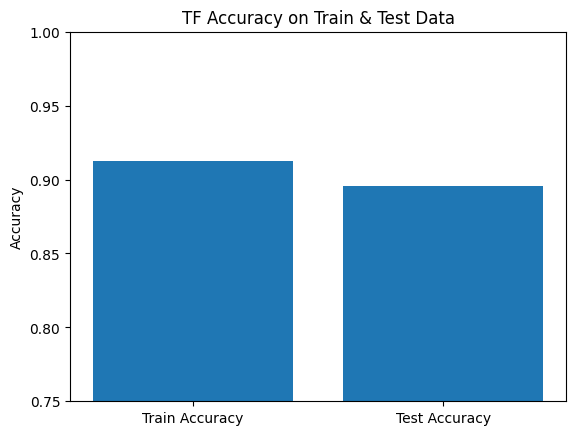

In [ ]:
# Display the accuracy on both training and testing datasets
train_acc =  accuracy_score(y_train, train_pred_cv)  # predictive accuracy for train data
test_acc_p1 = accuracy_score(y_test, test_pred_cv)  # part 1 predictive accuracy for test data

x_vals = ['Train Accuracy', 'Test Accuracy']
y_vals = [train_acc, test_acc_p1]

# plot that train and test accuracies
plt.bar(x_vals, y_vals)
plt.title('TF Accuracy on Train & Test Data')
plt.ylabel('Accuracy'); plt.ylim(0.75, 1.0)
plt.show()

### **Part 2 (TF-IDF)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score

# define term-frequency inverse document frequency model
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
nb_clf = BernoulliNB()

nb_clf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_clf.predict(X_test_tfidf)

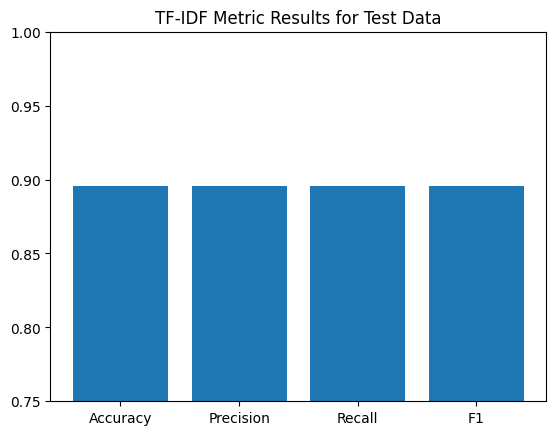

In [ ]:
# map each metric key to its value
metrics = {
    'Accuracy':  accuracy_score(y_test, y_pred_tfidf),
    'Precision': precision_score(y_test, y_pred_tfidf, average='macro'),
    'Recall':    recall_score(y_test, y_pred_tfidf, average='macro'),
    'F1':        f1_score(y_test, y_pred_tfidf, average='macro')
}

test_acc_p2 = metrics['Accuracy']

# plot the metrics in a bar plot
plt.bar(list(metrics.keys()), list(metrics.values()))
plt.title('TF-IDF Metric Results for Test Data')
plt.ylim(0.75, 1.0); plt.show()

### **Part 3 & 4 Util**

Define a method to create a basic keras CNN model that can be utilised for analysis in parts 3 & 4 respectively

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

# define number of classes
class_count = len(np.unique(y_test))
assert class_count == 4

def build_simple_cnn(input_dimen, embedding_dimen, embedding_matrix, trainable=True):
    """
    Given the values for the hyperparammeters input_dimen, output_dimen, weights, and trainable
    return a new basic sequential CNN model.
    """
    return Sequential([
        Embedding(
            input_dim=input_dimen,
            output_dim=embedding_dimen,
            weights=[embedding_matrix],
            trainable=trainable
        ),

        Conv1D(filters=64, kernel_size=3, activation='relu'), # single convolution layer
        GlobalAveragePooling1D(),                  # single pooling layer
        Dense(class_count, activation='softmax')   # single output layer
    ])

### **Part 3**

In [ ]:
# tokenise the corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test]))
token_index = tokenizer.word_index
vocab_size = len(token_index) + 1

# convert text to sequence of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

MAX_SEQ_LENGTH = 70  # max number of words per instance
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH)

In [ ]:
backend.clear_session()

# define the embedding dimensions for part 3
EMEDDING_DIMEN_P3 = 50

# create randomised matrix with vocab_size number of rows, and 50 columns/dimensions
# Mutliply each value in said matrix by 2, then subtract 1 to put each value on a [-1, 1] continuum
# as opposed to the [0, 1] continuum they startted on
rand_embedded_values = 2 * np.random.rand(vocab_size, EMEDDING_DIMEN_P3) - 1

model = build_simple_cnn(
    input_dimen=vocab_size,
    embedding_dimen=EMEDDING_DIMEN_P3,
    embedding_matrix=rand_embedded_values
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,599,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,599,800 (13.73 MB)

 Trainable params: 3,599,800 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# one-hot-encode the output variable/class label
y_train_cat = to_categorical(y_train, num_classes=class_count)
y_test_cat = to_categorical(y_test, num_classes=class_count)

history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=10,
    batch_size=500,
    validation_data=(X_test_pad, y_test_cat),
    verbose=1,
)

# save accuracy of model for step 6 analysis
_, test_acc_p3 = model.evaluate(X_test_pad, y_test_cat)
f'Test Acc: {test_acc_p3}'

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5302 - loss: 1.1548 - val_accuracy: 0.8701 - val_loss: 0.4081
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8872 - loss: 0.3548 - val_accuracy: 0.8954 - val_loss: 0.3259
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9136 - loss: 0.2733 - val_accuracy: 0.9063 - val_loss: 0.2986
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9266 - loss: 0.2289 - val_accuracy: 0.9075 - val_loss: 0.2866
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9354 - loss: 0.2019 - val_accuracy: 0.9067 - val_loss: 0.2828
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9439 - loss: 0.1758 - val_accuracy: 0.9093 - val_loss: 0.2776
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9503 - loss: 0.1566 - val_accuracy: 0.9097 - val_loss: 0.2784
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9560 - loss: 0.1394 - val_accuracy: 0

'Test Acc: 0.9090789556503296'

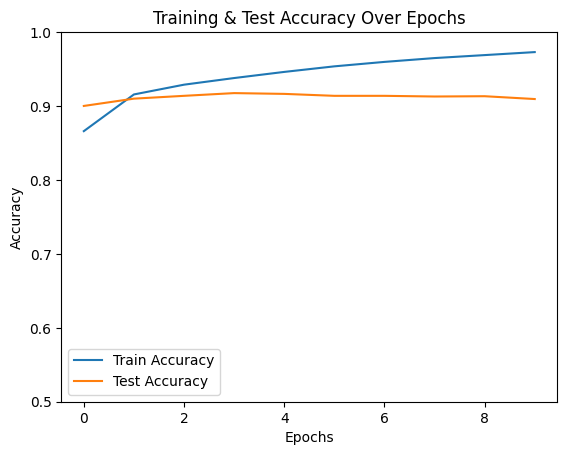

In [ ]:
# Plot accuracy over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Test Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.ylim(0.5, 1.0)
plt.legend()
plt.title('Training & Test Accuracy Over Epochs'); plt.show()


### **Part 4**

In [ ]:
# download glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-21 20:24:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-21 20:24:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-21 20:24:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
def glove_embedding_matrix(_token_index, embedding_dimen):
    """
    given some tokenised text, and an embedding dimension, construct
    a word embedding matrix using the GloVe embeddings.
    """
    assert embedding_dimen in {50, 100, 200, 300}  # possible GloVe embeddings
    word_vectors = {}

    # open the embedding file and retrieve the vectors for each word
    with open(f'./glove.6B.{embedding_dimen}d.txt', encoding="utf8") as f:
        for line in f:
            arr = line.split()
            word, coefs = arr[0], arr[1:]
            word_vectors[word] = np.asarray(coefs, dtype='float32')

    # create embedding matrix for each token in the corpus
    embedding_matrix = np.zeros((vocab_size, embedding_dimen))
    for token, index in _token_index.items():
        if token in word_vectors.keys():
            embedding_matrix[index] = word_vectors[token]
        else:
            # makes the random vecor values between [-1,1] instead of [0,1]
            embedding_matrix[index] = 2 * np.random.rand(1, embedding_dimen) - 1
    return embedding_matrix

In [ ]:
backend.clear_session()

# generate an embedding matrix using the pretrained 100 dimensional GloVe embedding
EMBEDDING_DIMEN_P4 = 100
embedding_matrix = glove_embedding_matrix(token_index, EMBEDDING_DIMEN_P4)

model = build_simple_cnn(
    input_dimen=vocab_size,
    embedding_dimen=EMBEDDING_DIMEN_P4,
    embedding_matrix=embedding_matrix,
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       7,199,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,199,600 (27.46 MB)

 Trainable params: 7,199,600 (27.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# one-hot-encode the output variable/class label
y_train_cat = to_categorical(y_train, num_classes=class_count)
y_test_cat = to_categorical(y_test, num_classes=class_count)

history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=10,
    batch_size=500,
    validation_data=(X_test_pad, y_test_cat),
)

# save test accuracy fro further analyssi in part 6
_, test_acc_p4 = model.evaluate(X_test_pad, y_test_cat)
f'Test Acc: {test_acc_p4}'

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7952 - loss: 0.7047 - val_accuracy: 0.9001 - val_loss: 0.3140
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9147 - loss: 0.2738 - val_accuracy: 0.9100 - val_loss: 0.2786
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9281 - loss: 0.2264 - val_accuracy: 0.9138 - val_loss: 0.2647
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9376 - loss: 0.1923 - val_accuracy: 0.9175 - val_loss: 0.2640
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9468 - loss: 0.1650 - val_accuracy: 0.9164 - val_loss: 0.2561
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9542 - loss: 0.1444 - val_accuracy: 0.9138 - val_loss: 0.2621
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9612 - loss: 0.1244 - val_accuracy: 0.9138 - val_loss: 0.2739
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9658 - loss: 0.1074 - val_accuracy: 0

'Test Acc: 0.9094736576080322'

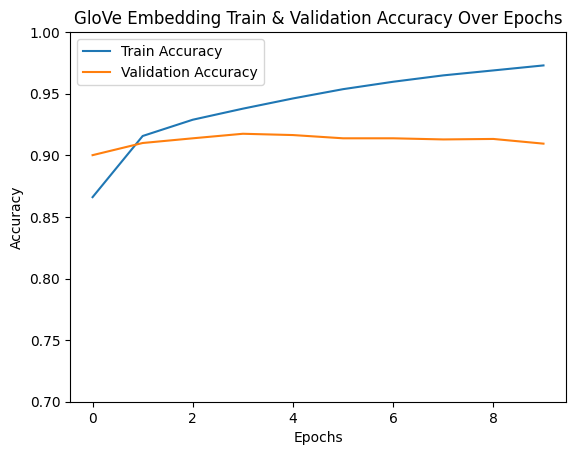

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# plot the change in trainn and test accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Test Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.ylim(0.7, 1.0)
plt.legend()
plt.title('GloVe Embedding Train & Test Accuracy Over Epochs')
plt.show()

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


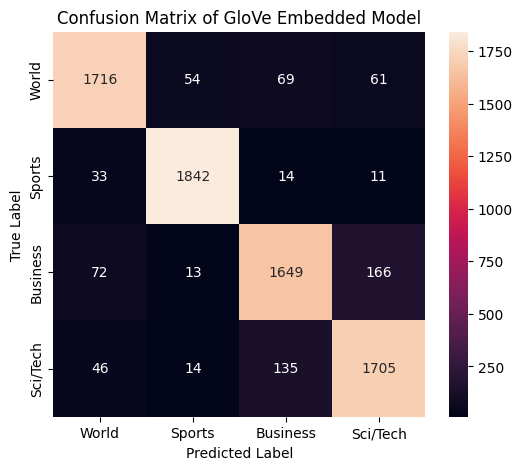

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_p4 = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_p4, axis=1)  # find the class labels

# create confusion matrix based upon part 4 predictions made
cm = confusion_matrix(y_test, y_pred_classes, labels=range(class_count))
labels = ["World", "Sports", "Business", "Sci/Tech"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label"); plt.ylabel("True Label")
plt.title("Confusion Matrix of GloVe Embedded Model")
plt.show()

### **Part 5**

Aply text preprocessing to improve the models. This consists of remove the backslashes dotted throughout each instance, as well as removing punctuation and unnecassary whitespaces.

In [ ]:
import string
import re

def remove_back_slashes(text: str) -> str:
    return text.replace('\\', ' ')

def remove_punt(text: str) -> str:
    for ch in string.punctuation:
        text = text.replace(ch, ' ')
    return text

def remove_extra_whitespace(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)

def apply_preprocessing(text: str) -> str:
    text = text.lower()

    text = remove_back_slashes(text)
    text = remove_punt(text)  # try remove all punct except . and ,
    text = remove_extra_whitespace(text)

    return text

def preprocess_text(df: pd.DataFrame):
    df_c = df.copy()
    df_c['Text'] = df_c['Text'].apply(lambda text: apply_preprocessing(text))
    df_c.drop(columns=['Title', 'Description'], inplace=True)
    return df_c

processed_train = preprocess_text(train)
processed_test = preprocess_text(test)

# show the changes to the text
processed_train['Text'][:5], train['Text'][:5]

(0    wall st bears claw back into the black reuters...
 1    carlyle looks toward commercial aerospace reut...
 2    oil and economy cloud stocks outlook reuters r...
 3    iraq halts oil exports from main southern pipe...
 4    oil prices soar to all time record posing new ...
 Name: Text, dtype: object,
 0    Wall St. Bears Claw Back Into the Black (Reute...
 1    Carlyle Looks Toward Commercial Aerospace (Reu...
 2    Oil and Economy Cloud Stocks' Outlook (Reuters...
 3    Iraq Halts Oil Exports from Main Southern Pipe...
 4    Oil prices soar to all-time record, posing new...
 Name: Text, dtype: object)

Define the new train, validation, and test splits, with the validation data being 10 percent of the train instances.

In [ ]:
from sklearn.model_selection import train_test_split

X, y = processed_train['Text'], processed_train['Class Index']
X_test_, y_test = processed_test['Text'], processed_test['Class Index']

# create new training and validation sets using stratified selection
# to get an even number of samples per class!
X_train_, X_val, y_train_, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_)   # fit tokenizer only on the train
token_index = tokenizer.word_index
vocab_size = len(token_index) + 1

# convert text to sequence of tokens
X_train_seq = tokenizer.texts_to_sequences(X_train_)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test_)

# pad tokens to ensure equal length vectors
MAX_SEQ_LENGTH = 70  # max number of words per instance
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH)

Improved keras CNN model, added features and layers:
- SpatialDropout
- Two `Conv1D(filters=128, kernel_size=5, activation='relu')`
- BatchNormalization layers
- Added MaxPooling1D after first convolution layer
- Fully connected layer and dropout placed before output layer

In [ ]:
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D, Dropout, BatchNormalization,

backend.clear_session()

# utilise the same 100 dimensional GloVe emebddin from part 4
EMBEDDING_DIM_P5=100
embedding_matrix = glove_embedding_matrix(token_index, embedding_dimen=EMBEDDING_DIM_P5)
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=EMBEDDING_DIM_P5,
        weights=[embedding_matrix],
        trainable=True
    ),
    SpatialDropout1D(0.25),  # randomly removes entire input feature vectors

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=4, strides=2),

    Conv1D(filters=128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(class_count, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       6,258,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,258,600 (23.87 MB)

 Trainable params: 6,258,600 (23.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# reduce learning rate from 0.001 -> 0.0002
model.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# one-hot-encode the output variable/class label
y_train_cat = to_categorical(y_train_, num_classes=class_count)
y_val_cat = to_categorical(y_val, num_classes=class_count)
y_test_cat = to_categorical(y_test, num_classes=class_count)

history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=15,
    batch_size=256,
    validation_data=(X_val_pad, y_val_cat),
)

# save test accuracy for analysis in part 6
_, test_acc_p5 = model.evaluate(X_test_pad, y_test_cat)
f'Test Acc: {test_acc_p5}'

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.7702 - loss: 0.6310 - val_accuracy: 0.9015 - val_loss: 0.2989
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8847 - loss: 0.3356 - val_accuracy: 0.9097 - val_loss: 0.2672
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8990 - loss: 0.2919 - val_accuracy: 0.9123 - val_loss: 0.2479
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9065 - loss: 0.2673 - val_accuracy: 0.9183 - val_loss: 0.2368
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9138 - loss: 0.2487 - val_accuracy: 0.9168 - val_loss: 0.2364
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9190 - loss: 0.2304 - val_accuracy: 0.9220 - val_loss: 0.2252
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9238 - loss: 0.2153 - val_accuracy: 0.9257 - val_loss: 0.2177
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9297 - loss: 0.2009 - val_accuracy:

'Test Acc: 0.9276315569877625'

### **Step 6**

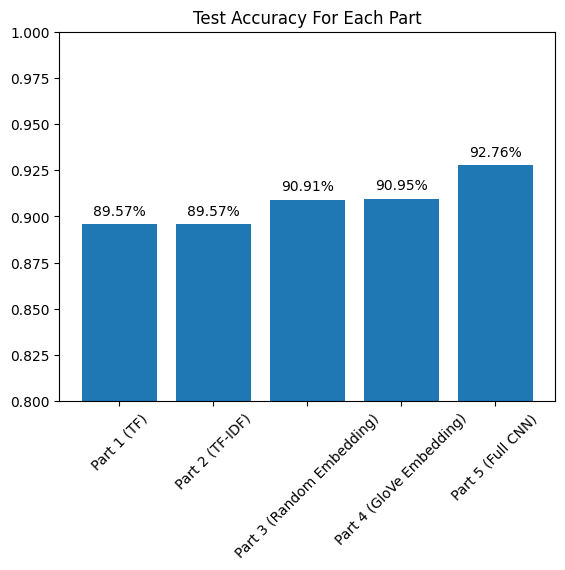

In [ ]:
accuracies = {
    'Part 1 (TF)': test_acc_p1,
    'Part 2 (TF-IDF)': test_acc_p2,
    'Part 3 (Random Embedding)': test_acc_p3,
    'Part 4 (GloVe Embedding)': test_acc_p4,
    'Part 5 (Full CNN)': test_acc_p5,
}

plt.bar(list(accuracies.keys()), list(accuracies.values()))
plt.title('Test Accuracy For Each Part')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

for key, value in accuracies.items(): # Annotate each bar with its value
    plt.text(
        x=key,
        y=value+0.005,
        s=f'{(value*100):.2f}%',
        ha='center'
    )
plt.show()